In [26]:
"""
Jupytext-style script for:
02_baseline_lstm_single_station.ipynb
"""



'\nJupytext-style script for:\n02_baseline_lstm_single_station.ipynb\n'

# Baseline LSTM for single-station salinity forecasting

This notebook trains a first baseline 1-step-ahead LSTM model to predict salinity at a single station using the cleaned per-station datasets in `data/clean/`. The LSTM forecast is compared against a simple persistence baseline that assumes salinity at the next step equals the last observed value. The goal is to establish a clear but simple reference model for later improvements.



## Imports and configuration

This section imports the core scientific Python stack, scikit-learn metrics and scalers, and TensorFlow Keras for the LSTM model. It also defines paths to the cleaned data and a small set of configuration parameters such as the station name, lookback window, and train/validation/test fractions. These parameters can be edited to run the notebook for a different station or a different temporal context.



In [27]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split  # imported for completeness, not used directly
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras import models, layers, callbacks

# Base directories
BASE_DIR = Path(".").resolve()
CLEAN_DIR = BASE_DIR / "data" / "clean"

# Station configuration (change as needed)
STATION_NAME = "AnDinh"  # e.g. "AnDinh", "CaMau", ...

# Modelling configuration
LOOKBACK = 48        # number of time steps in input sequence
TEST_FRACTION = 0.2  # fraction of samples (by time) reserved for test
VAL_FRACTION = 0.2   # fraction of samples (by time) reserved for validation

# Set a simple random seed for reproducibility of numpy / TF initialisation
np.random.seed(42)



## Load station dataset and basic inspection

We now load the cleaned per-station dataset from `data/clean/`. Each file is expected to have a `datetime` column (used as the index), a `salinity` column, and a number of input features derived from discharge, water levels, and rainfall. We perform a quick structural inspection and plot the salinity time series to understand coverage and variability for the chosen station.



Loaded station file: C:\Users\User\Desktop\Disertation\data\clean\station_AnDinh.csv

Head:
                     salinity  Q_MyThuan_Station Code  Q_MyThuan_Value  \
datetime                                                                 
1996-02-02 03:00:00       0.1                     NaN              NaN   
1996-02-02 05:00:00       0.1                     NaN              NaN   
1996-02-02 07:00:00       0.1                     NaN              NaN   
1996-02-04 17:00:00       0.1                     NaN              NaN   
1996-02-04 19:00:00       0.1                     NaN              NaN   

                     Q_CanTho_Station Code  Q_CanTho_Value  \
datetime                                                     
1996-02-02 03:00:00                    NaN             NaN   
1996-02-02 05:00:00                    NaN             NaN   
1996-02-02 07:00:00                    NaN             NaN   
1996-02-04 17:00:00                    NaN             NaN   
1996-02-04 19:00:

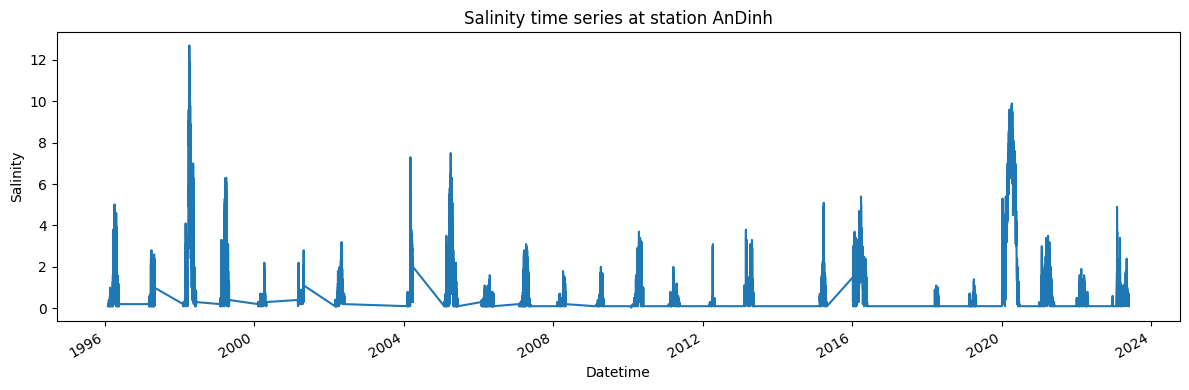

In [28]:
# Build path and load per-station dataset
station_file = CLEAN_DIR / f"station_{STATION_NAME}.csv"
if not station_file.exists():
    raise FileNotFoundError(f"Could not find cleaned file for station {STATION_NAME!r}: {station_file}")

df = pd.read_csv(station_file, index_col="datetime", parse_dates=True)

print(f"Loaded station file: {station_file}")
print("\nHead:")
print(df.head())

print("\nInfo:")
print(df.info())

print("\nTime coverage and shape:")
print(f"Start: {df.index.min()}")
print(f"End:   {df.index.max()}")
print(f"Shape: {df.shape}")

# Plot salinity time series
if "salinity" not in df.columns:
    raise KeyError("Expected 'salinity' column in cleaned station dataset.")

plt.figure(figsize=(12, 4))
df["salinity"].plot()
plt.title(f"Salinity time series at station {STATION_NAME}")
plt.ylabel("Salinity")
plt.xlabel("Datetime")
plt.tight_layout()
plt.show()



## Select features and drop non-numeric / station code columns

We use `salinity` as the prediction target and treat the remaining numeric columns as candidate input features. Non-numeric columns (for example station codes or text flags) are removed. In particular, any column ending with `"Station Code"` is dropped. After this step we identify the final list of feature columns and print basic missingness statistics to understand data quality before further filtering.



In [29]:
# Drop non-numeric columns
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

# Additionally drop obvious station code columns
station_code_cols = [c for c in df.columns if c.endswith("Station Code")]

cols_to_drop = sorted(set(non_numeric_cols).union(station_code_cols))
if cols_to_drop:
    print("Dropping non-numeric / station code columns:")
    print(cols_to_drop)
    df = df.drop(columns=cols_to_drop)

# Confirm target presence
target_col = "salinity"
if target_col not in df.columns:
    raise KeyError(f"Target column '{target_col}' not found after dropping non-numeric columns.")

# Define feature columns (excluding the explicit target)
feature_cols = [c for c in df.columns if c != target_col]

print(f"\nNumber of feature columns: {len(feature_cols)}")
print("Feature columns:")
print(feature_cols)

# Basic missingness stats (percentage of NaNs per feature)
missing_pct = df[feature_cols + [target_col]].isna().mean() * 100
print("\nMissingness (% NaN) per column:")
print(missing_pct.sort_values(ascending=False).round(2))



Dropping non-numeric / station code columns:
['H_CaiLay_Station Code', 'H_CanTho_Station Code', 'H_ChoLach_Station Code', 'H_ChoMoi_Station Code', 'H_DaiNgai_Station Code', 'H_MyTho_Station Code', 'H_MyThuan_Station Code', 'H_PhungHiep_Station Code', 'H_TanChau_Station Code', 'H_TanHiep_Station Code', 'H_VamKenh_Station Code', 'H_VamNao_Station Code', 'H_ViThanh_Station Code', 'Q_CanTho_Station Code', 'Q_MyThuan_Station Code', 'Q_VamNao_Station Code', 'rain_Batri_Station Code', 'rain_BenLuc_Station Code', 'rain_CaMau_Station Code', 'rain_CaiBe_Station Code', 'rain_CaiLay_Station Code', 'rain_CanTho_Station Code', 'rain_ChauDoc_Station Code', 'rain_ChoMoi_Station Code', 'rain_DaiNgai_Station Code', 'rain_MyTho_Station Code', 'rain_MyThuan_Station Code', 'rain_PhungHiep_Station Code', 'rain_TanChau_Station Code', 'rain_TanHiep_Station Code', 'rain_VamKenh_Station Code', 'rain_VamNao_Station Code', 'rain_ViThanh_Station Code']

Number of feature columns: 33
Feature columns:
['Q_MyThuan_Va

## Drop rows with missing target / too many missing inputs

The LSTM expects contiguous sequences without missing values. For this baseline we take an intentionally simple and strict approach:

1. Drop any rows where the salinity target is missing.
2. Drop any remaining rows with missing values in the input features.

This guarantees that all sequences are fully populated, at the cost of discarding time steps where any driver is missing. We then print the final shape and updated date range for the station.



In [30]:
# 1) Drop rows with missing target
df = df.dropna(subset=[target_col])

# 2) Drop any remaining rows with NaNs in features (for simplicity)
if feature_cols:
    before_dropna = len(df)
    df_before_feature_drop = df.copy()
    df = df.dropna(subset=feature_cols)
    dropped_rows = before_dropna - len(df)
    print(f"Rows dropped due to NaNs in features: {dropped_rows}")

    # If this removes all rows, fall back to using salinity-only
    # autoregressive input to keep a workable baseline.
    if len(df) == 0:
        print(
            "All rows were dropped when requiring complete data for all drivers.\n"
            "Falling back to using salinity-only (autoregressive) input."
        )
        df = df_before_feature_drop[[target_col]].dropna()
        feature_cols = []

print("\nFinal cleaned shape and coverage:")
print(f"Shape: {df.shape}")
print(f"Start: {df.index.min()}")
print(f"End:   {df.index.max()}")

if len(df) <= LOOKBACK + 10:
    raise ValueError(
        f"Not enough rows ({len(df)}) after cleaning for lookback={LOOKBACK}. "
        "Consider reducing LOOKBACK or relaxing missing-data thresholds."
    )



Rows dropped due to NaNs in features: 17892
All rows were dropped when requiring complete data for all drivers.
Falling back to using salinity-only (autoregressive) input.

Final cleaned shape and coverage:
Shape: (17892, 1)
Start: 1996-02-02 03:00:00
End:   2023-05-29 23:00:00


## Build supervised learning sequences (sliding windows)

We now convert the cleaned time series into supervised learning sequences. The goal is to predict salinity at time step `t+1` using the previous `LOOKBACK` time steps of all features, including past salinity. For each valid time index we extract:

- An input window `X[i]` of shape `(LOOKBACK, n_features)` containing the last `LOOKBACK` rows.
- A scalar target `y[i] = salinity(t+1)`.

The helper function `create_sequences` implements this sliding-window logic. We then apply it to the station DataFrame and inspect the resulting array shapes.



In [31]:
def create_sequences(data: np.ndarray, target: np.ndarray, lookback: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Build supervised sequences for 1-step-ahead prediction.

    Parameters
    ----------
    data : np.ndarray
        Array of shape (T, F) containing features (including past salinity if desired).
    target : np.ndarray
        Array of shape (T,) containing the target salinity series.
    lookback : int
        Number of time steps in each input window.

    Returns
    -------
    X : np.ndarray
        Array of shape (N_samples, lookback, F) with sliding windows of features.
    y : np.ndarray
        Array of shape (N_samples,) with targets at t+1.
    """
    T, F = data.shape
    X_list: list[np.ndarray] = []
    y_list: list[float] = []

    # We use windows ending at t, predicting target at t+1
    for t in range(lookback - 1, T - 1):
        window = data[t - lookback + 1 : t + 1]  # shape (lookback, F)
        X_list.append(window)
        y_list.append(target[t + 1])

    X = np.stack(X_list, axis=0)
    y = np.array(y_list)

    return X, y


# Build full feature matrix for sequences, including past salinity explicitly
all_feature_cols = [target_col] + feature_cols  # salinity first, then other features
data_all = df[all_feature_cols].values.astype("float32")
target_all = df[target_col].values.astype("float32")

X_all, y_all = create_sequences(data_all, target_all, lookback=LOOKBACK)

# Build corresponding time index for each target (t+1)
time_index_all = df.index[LOOKBACK:]

print("\nSequence shapes:")
print(f"X_all shape: {X_all.shape}  (samples, lookback, n_features)")
print(f"y_all shape: {y_all.shape}")
print(f"Number of timestamps: {len(time_index_all)}")




Sequence shapes:
X_all shape: (17844, 48, 1)  (samples, lookback, n_features)
y_all shape: (17844,)
Number of timestamps: 17844


## Train/validation/test split by time

To respect temporal ordering, we split the sequence data chronologically rather than shuffling. The earliest portion is used for training, followed by a validation block, and the most recent samples are reserved for testing. The split is controlled by `VAL_FRACTION` and `TEST_FRACTION`, applied to the total number of sequence samples.



In [32]:
n_samples = X_all.shape[0]
n_test = int(np.floor(TEST_FRACTION * n_samples))
n_val = int(np.floor(VAL_FRACTION * n_samples))
n_train = n_samples - n_val - n_test

if n_train <= 0 or n_val <= 0 or n_test <= 0:
    raise ValueError(
        f"Invalid split sizes with n_samples={n_samples}, "
        f"TEST_FRACTION={TEST_FRACTION}, VAL_FRACTION={VAL_FRACTION}."
    )

train_end = n_train
val_end = n_train + n_val

X_train_raw = X_all[:train_end]
X_val_raw = X_all[train_end:val_end]
X_test_raw = X_all[val_end:]

y_train_raw = y_all[:train_end]
y_val_raw = y_all[train_end:val_end]
y_test_raw = y_all[val_end:]

time_train = time_index_all[:train_end]
time_val = time_index_all[train_end:val_end]
time_test = time_index_all[val_end:]

print("Split sizes (samples):")
print(f"Train: {X_train_raw.shape[0]}")
print(f"Val:   {X_val_raw.shape[0]}")
print(f"Test:  {X_test_raw.shape[0]}")
print(f"Total: {n_samples}")



Split sizes (samples):
Train: 10708
Val:   3568
Test:  3568
Total: 17844


## Scale features and target

Neural networks generally train more reliably when inputs and targets are standardised. We therefore apply `StandardScaler` separately to:

- All features (salinity + drivers), fitted on the training data only.
- The target salinity series, again fitted on the training targets only.

To scale features, we temporarily flatten the `(N, LOOKBACK, F)` arrays to `(N*LOOKBACK, F)`, fit the scaler, and then reshape back. The target is scaled as a one-dimensional array and will later be inverse-transformed to evaluate performance in physical units.



In [33]:
n_features = X_train_raw.shape[2]

# Feature scaler
scaler_X = StandardScaler()
X_train_flat = X_train_raw.reshape(-1, n_features)
scaler_X.fit(X_train_flat)


def scale_features(X: np.ndarray, scaler: StandardScaler) -> np.ndarray:
    n, L, F = X.shape
    X_flat = X.reshape(-1, F)
    X_scaled_flat = scaler.transform(X_flat)
    return X_scaled_flat.reshape(n, L, F)


X_train_scaled = scale_features(X_train_raw, scaler_X)
X_val_scaled = scale_features(X_val_raw, scaler_X)
X_test_scaled = scale_features(X_test_raw, scaler_X)

# Target scaler
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_raw.reshape(-1, 1)).reshape(-1)
y_val_scaled = scaler_y.transform(y_val_raw.reshape(-1, 1)).reshape(-1)
y_test_scaled = scaler_y.transform(y_test_raw.reshape(-1, 1)).reshape(-1)

print("\nScaled shapes:")
print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_val_scaled:   {X_val_scaled.shape}")
print(f"X_test_scaled:  {X_test_scaled.shape}")
print(f"y_train_scaled: {y_train_scaled.shape}")




Scaled shapes:
X_train_scaled: (10708, 48, 1)
X_val_scaled:   (3568, 48, 1)
X_test_scaled:  (3568, 48, 1)
y_train_scaled: (10708,)


## Persistence baseline (benchmark)

Before training the LSTM, we define a simple persistence baseline. For each prediction, persistence assumes:

\\[
\\hat{y}_{t+1}^{(\\text{persist})} = y_t
\\]

i.e. salinity at the next time step equals the last observed salinity in the input window. We compute this baseline directly in the original (unscaled) units by reading the final value of the salinity feature from the raw test windows. We then calculate MAE, RMSE, and R² on the test set for later comparison with the LSTM.



In [34]:
# Salinity feature index within all_feature_cols (we put it first)
salinity_feature_index = all_feature_cols.index(target_col)

# Persistence prediction: next-step salinity = last salinity in input window
y_pred_persist = X_test_raw[:, -1, salinity_feature_index]

# Ground truth (original units)
y_true_test = y_test_raw

# Compute metrics in original units
mae_persist = mean_absolute_error(y_true_test, y_pred_persist)
# Older scikit-learn versions do not support squared=False, so compute RMSE manually
rmse_persist = mean_squared_error(y_true_test, y_pred_persist) ** 0.5
r2_persist = r2_score(y_true_test, y_pred_persist)

print("Persistence baseline metrics (test set, original units):")
print(f"MAE:  {mae_persist:.4f}")
print(f"RMSE: {rmse_persist:.4f}")
print(f"R²:   {r2_persist:.4f}")



Persistence baseline metrics (test set, original units):
MAE:  0.2692
RMSE: 0.4224
R²:   0.9674


## Define and train the LSTM model

We now define a simple baseline LSTM model with one LSTM layer followed by a small dense block. The model predicts the next-step salinity from the scaled sequence of inputs. Early stopping on validation loss is used to avoid overfitting. This model is intentionally modest and is meant to serve as a baseline rather than a fully tuned architecture.



Epoch 1/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.3656 - val_loss: 0.1544
Epoch 2/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 0.1704 - val_loss: 0.0913
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 0.1022 - val_loss: 0.0751
Epoch 4/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.0975 - val_loss: 0.0743
Epoch 5/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0948 - val_loss: 0.0722
Epoch 6/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 0.0898 - val_loss: 0.0645
Epoch 7/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.0830 - val_loss: 0.0570
Epoch 8/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0869 - val_loss: 0.0575
Epoch 9/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0778 - val_loss: 0.0561
Epoch 10/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0774 - val_loss: 0.0554
Epoch 11/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.0721 - val_loss: 0.0581
Epoch 12/100
168/168 ━━━━━━

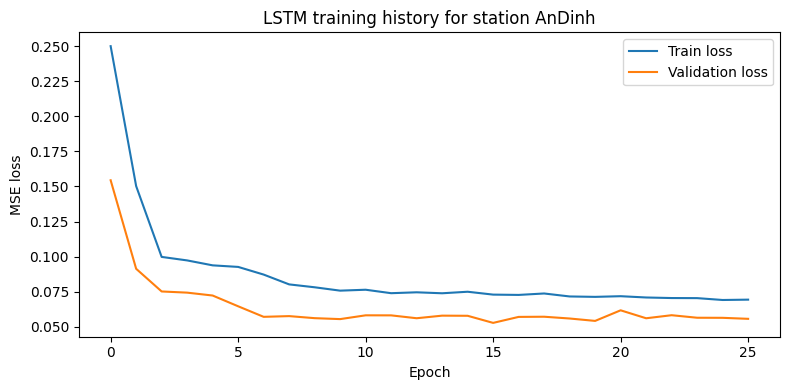

In [35]:
n_features = X_train_scaled.shape[2]

model = models.Sequential(
    [
        layers.Input(shape=(LOOKBACK, n_features)),
        layers.LSTM(64, return_sequences=False),
        layers.Dense(32, activation="relu"),
        layers.Dense(1),
    ]
)

model.compile(loss="mse", optimizer="adam")

early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

history = model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1,
)

# Plot training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title(f"LSTM training history for station {STATION_NAME}")
plt.legend()
plt.tight_layout()
plt.show()



## Evaluate LSTM on the test set

With the trained model in hand, we generate predictions on the scaled test sequences and then inverse-transform these predictions back to the original salinity units. We compute MAE, RMSE, and R², and compare them against the persistence baseline in a small table. Finally, we produce diagnostic plots: a time series comparison over part of the test period and a scatter plot of observed versus predicted salinity.



112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
LSTM metrics (test set, original units):
MAE:  0.2227
RMSE: 0.3642
R²:   0.9758

Test-set metrics comparison:
                MAE    RMSE      R2
Persistence  0.2692  0.4224  0.9674
LSTM         0.2227  0.3642  0.9758


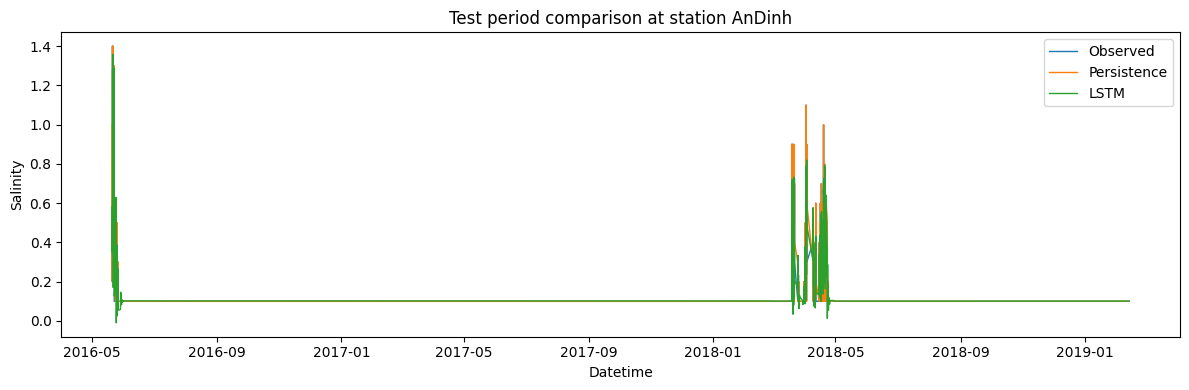

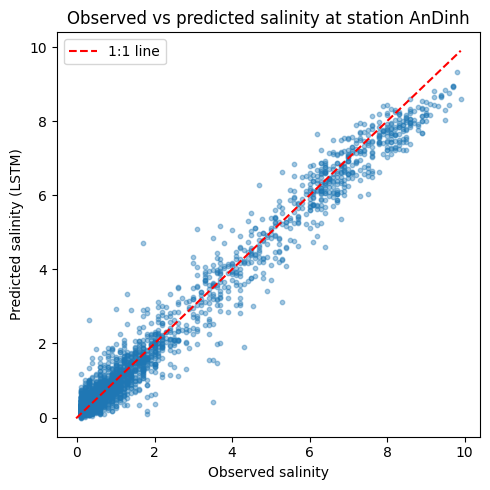

: 

In [ ]:
# Predict on test set
y_pred_test_scaled = model.predict(X_test_scaled).reshape(-1, 1)

# Inverse-transform predictions and (optionally) scaled test targets
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled).reshape(-1)
y_true_test = y_test_raw  # already in original units

# LSTM metrics
mae_lstm = mean_absolute_error(y_true_test, y_pred_test)
rmse_lstm = mean_squared_error(y_true_test, y_pred_test) ** 0.5
r2_lstm = r2_score(y_true_test, y_pred_test)

print("LSTM metrics (test set, original units):")
print(f"MAE:  {mae_lstm:.4f}")
print(f"RMSE: {rmse_lstm:.4f}")
print(f"R²:   {r2_lstm:.4f}")

# Combine metrics into a small comparison table
metrics_df = pd.DataFrame(
    {
        "MAE": [mae_persist, mae_lstm],
        "RMSE": [rmse_persist, rmse_lstm],
        "R2": [r2_persist, r2_lstm],
    },
    index=["Persistence", "LSTM"],
)

print("\nTest-set metrics comparison:")
print(metrics_df.round(4))

# Time series plot over a subset of the test period
n_plot = min(500, len(y_true_test))
time_plot = time_test[:n_plot]

plt.figure(figsize=(12, 4))
plt.plot(time_plot, y_true_test[:n_plot], label="Observed", linewidth=1)
plt.plot(time_plot, y_pred_persist[:n_plot], label="Persistence", linewidth=1)
plt.plot(time_plot, y_pred_test[:n_plot], label="LSTM", linewidth=1)
plt.xlabel("Datetime")
plt.ylabel("Salinity")
plt.title(f"Test period comparison at station {STATION_NAME}")
plt.legend()
plt.tight_layout()
plt.show()

# Scatter plot observed vs LSTM prediction
plt.figure(figsize=(5, 5))
plt.scatter(y_true_test, y_pred_test, alpha=0.4, s=10)
max_val = max(y_true_test.max(), y_pred_test.max())
min_val = min(y_true_test.min(), y_pred_test.min())
plt.plot([min_val, max_val], [min_val, max_val], "r--", label="1:1 line")
plt.xlabel("Observed salinity")
plt.ylabel("Predicted salinity (LSTM)")
plt.title(f"Observed vs predicted salinity at station {STATION_NAME}")
plt.legend()
plt.tight_layout()
plt.show()



## Summary and next steps

This notebook trained a baseline 1-step-ahead LSTM model for station `STATION_NAME` using the cleaned hourly time series in `data/clean/`. After basic missing-data filtering there were sufficient samples to form sliding windows with a lookback of 48 time steps, and the data were split chronologically into training, validation, and test sets. A simple persistence model (salinity at the next step equals the last observed salinity) was used as a benchmark.

On the test set, the LSTM achieved the metrics shown in the comparison table above relative to persistence (MAE, RMSE, R²). Where the LSTM substantially outperforms persistence, it indicates that the model is extracting useful information from the recent history of salinity and the hydrological drivers. If performance is similar, the task may be largely persistence-dominated at this horizon, or the model and features may need to be refined.

This baseline can be extended in several directions: trying different lookback windows or model depths, incorporating additional derived predictors (for example tidal phase or seasonal indices), tuning hyperparameters, or moving to multi-step prediction. For now, the notebook provides a clear, reproducible reference for future LSTM experiments on Mekong salinity intrusion.
